In [ ]:
#  Importing necessary libraries
import numpy as np
#  Importing necessary libraries
import pandas as pd
#  Splitting data into train and test sets
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Masking, Bidirectional, Input
from sklearn.utils.class_weight import compute_class_weight
#  Calculating the AUC (Area Under Curve)
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
#  Importing necessary libraries
import matplotlib.pyplot as plt
#  Importing necessary libraries
import os
#  Computing the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-02-12 12:47:34.801510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-12 12:47:34.814089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-12 12:47:34.817984: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 12:47:34.827370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
def grouping(y, n, outs):
    # Initialize lists to store grouped predictions and corresponding labels
    preds_all = []
    ys_all = []

    # Loop through each unique user ID in the labels
    for user in np.unique(y):
        # Extract predictions and labels corresponding to the current user
        user_preds = outs[y == user]
        user_ground_truth = y[y == user]

        # Group predictions into chunks of size n
        for i in range(0, len(user_preds), n):
            preds_all.append(user_preds[i:i + n])  # Store prediction group
            ys_all.append(user)                     # Store the corresponding user ID
    return preds_all, ys_all  # Return grouped predictions and their labels


In [ ]:
def train_test(path='./'):
    # Initialize dictionary to store validation splits per user
    splits = {}

    # Get all .npy files in the directory, sorted
    all_files = np.sort(np.array([os.path.join(path, f) for f in os.listdir(path) if f.endswith('.npy')]))

    # Set seed for reproducibility
    np.random.seed(42)

    # Loop through each file (each representing a user)
    for file in all_files:
        # Extract user ID from filename
        user = file.split('/')[-1].split('.npy')[0]

        # Load genuine user data
        gen_data = np.load(file)

        # Load and stack all other users' data as imposter data
        imp_data = [np.load(f) for f in all_files[all_files != file]]
        imp_data = np.vstack(imp_data)

        # 80/20 train-validation split for genuine and imposter data
        split_idx_gen = int(len(gen_data)*0.8)
        split_idx_imp = int(len(imp_data)*0.8)
        gen_train_X = gen_data[:split_idx_gen]
        gen_val_X = gen_data[split_idx_gen:]
        imp_train_X = imp_data[:split_idx_imp]
        imp_val_X = imp_data[split_idx_imp:]

        # (optional) Stratified undersampling (currently commented out)
        # imp_train_X, imp_val_X = stratified_undersample(len(gen_train_X), len(gen_val_X), imp_files)

        # Free memory for unused variables
        del gen_data, imp_data

        # Assign labels: 1 for genuine, 0 for imposters
        gen_train_y = np.ones((len(gen_train_X)))
        gen_val_y = np.ones((len(gen_val_X)))
        imp_train_y = np.zeros((len(imp_train_X)))
        imp_val_y = np.zeros((len(imp_val_X)))

        # Re-assign (redundantly) to ensure correctness
        gen_val_y = np.ones((len(gen_val_X)))
        imp_val_y = np.zeros((len(imp_val_X)))

        # Combine validation data and labels
        X_val = np.vstack([gen_val_X, imp_val_X])
        del gen_val_X, imp_val_X
        y_val = np.concatenate([gen_val_y, imp_val_y])
        del gen_val_y, imp_val_y

        # Store validation data for current user in splits dictionary
        splits[user + 'X_val'] = X_val
        del X_val
        splits[user + 'y_val'] = y_val
        del y_val

    # Return dictionary of user-wise validation splits
    return splits


In [ ]:
def binary_test(splits, n, model_path='./'):
    # Get sorted list of all trained model files (.keras)
    all_files = np.sort(np.array([os.path.join(model_path, f) for f in os.listdir(model_path) if f.endswith('.keras')]))

    # Initialize containers for overall evaluation
    results = []
    all_correct = 0
    all_incorrect = 0
    all_scores = []
    all_labels = []
    eers = []
    aucs = []

    # Loop through each user-specific trained model
    for file in all_files:
        correct = 0
        incorrect = 0
        print(file)

        # Extract user ID from filename
        user = file.split('/')[-1].split('_')[0]

        # Load corresponding validation data for this user
        X_val = splits[user + 'X_val']
        y_val = splits[user + 'y_val']

        # Load the trained model (compile=False since it's for inference)
        model = load_model(file, compile=False)

        # Generate prediction scores on validation data
        outs = model.predict(X_val)

        # Group predictions and ground truths by user-level chunks
        preds_all, ys_all = grouping(y_val, n, outs)
        scores = []
        ground_truths = []

        # Evaluate each grouped sequence
        for group, truth in zip(preds_all, ys_all):
            # Average score over n predictions
            score = np.average(group, axis=0)
            scores.append(score)
            all_scores.append(score)
            ground_truths.append(truth)

            # Convert score to binary prediction
            pred = 1 if score > 0.5 else 0
            all_labels.append(truth)

            # Track correct/incorrect predictions
            if pred == truth:
                correct += 1
            else:
                incorrect += 1

        # Compute ROC curve and AUC for this user
        fpr, tpr, _ = roc_curve(ground_truths, scores)
        auc = roc_auc_score(ground_truths, scores)

        # Calculate Equal Error Rate (EER)
        eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
        acc = correct / (correct + incorrect)

        # Store results for this user
        results.append({'User': user, 'n': n, 'EER': eer, 'AUC': auc})
        eers.append(eer)
        aucs.append(auc)
        print(f"EER: {eer:.4f}, AUC: {auc:.4f}, Acc: {acc:.4f}")

        # Update global correct/incorrect counts
        all_correct += correct
        all_incorrect += incorrect
        all_acc = all_correct / (all_correct + all_incorrect)

    # Print and compute overall accuracy across all users
    print(f'Overall Accuracy: {all_acc:.4f}')

    # Compute ROC and AUC on all predictions
    fpr, tpr, thr = roc_curve(all_labels, all_scores)
    auc = roc_auc_score(all_labels, all_scores)

    # Calculate global EER
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    eer_thr = thr[np.nanargmin(np.abs(fpr - (1 - tpr)))]

    # Append averaged results across all users
    results.append({'User': 'Mean', 'n': n, 'EER': np.mean(eers), 'AUC': np.mean(aucs)})
    print(f'Mean EER: {np.mean(eers):.4f}, Mean AUC: {np.mean(aucs):.4f}')

    # Convert probabilities into binary predictions using EER threshold
    binary_predictions = (all_scores >= eer_thr).astype(int)

    # Compute and display the overall confusion matrix
    cm = confusion_matrix(all_labels, binary_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative (0)", "Positive (1)"])
    disp.plot(cmap="viridis")

    return results


dict_keys(['0X_val', '0y_val', '1X_val', '1y_val', '10X_val', '10y_val', '11X_val', '11y_val', '12X_val', '12y_val', '13X_val', '13y_val', '14X_val', '14y_val', '15X_val', '15y_val', '16X_val', '16y_val', '17X_val', '17y_val', '18X_val', '18y_val', '19X_val', '19y_val', '2X_val', '2y_val', '20X_val', '20y_val', '21X_val', '21y_val', '22X_val', '22y_val', '23X_val', '23y_val', '24X_val', '24y_val', '25X_val', '25y_val', '26X_val', '26y_val', '27X_val', '27y_val', '28X_val', '28y_val', '29X_val', '29y_val', '3X_val', '3y_val', '30X_val', '30y_val', '4X_val', '4y_val', '5X_val', '5y_val', '6X_val', '6y_val', '7X_val', '7y_val', '8X_val', '8y_val', '9X_val', '9y_val'])
######################################################N==1######################################################
Gmail Models/binary_e_synth/0_min_val_loss.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step
EER: 0.3271, AUC: 0.7488, Acc: 0.8506
Overall Accuracy: 0.8506
Mean EER: 0.3271, Mean AUC: 0.7488


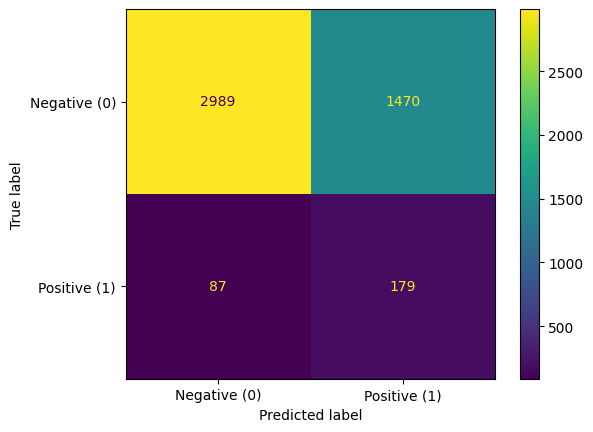

In [ ]:
# CROSS VALIDATION NEEDED
# OBSERVE IF TREND FOR GMAIL STABLE (BETTER MULTI THAN BINARY)
# for j in range(10):
splits = train_test('..data/data splits/binary')
print(splits.keys())
i = 1
while i <= 1:
    print(f'######################################################N=={i}######################################################')
    results = binary_test(splits, i, '..trained_models/binary_biLSTM_synth')
    results = pd.DataFrame(results)
    # results.to_csv(f'Gmail Results/binary/test.csv', index=False)
    if i == 1:
        i += 4
    else:
        i += 5